In [1]:
import pandas as pd
import requests

import riot_api_key as riot_api_key
import riot_consts as consts

ddragon_version = requests.get('https://ddragon.leagueoflegends.com/api/versions.json').json()[0]
ddragon_items = requests.get(
    ('http://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/item.json').format(
        version=ddragon_version)).json()
ddragon_champions = requests.get(
    ('http://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/championFull.json').format(
        version=ddragon_version)).json()

champions = pd.DataFrame.from_dict(ddragon_champions['data'], orient='index')
items = pd.DataFrame.from_dict(ddragon_items['data'], orient='index')


class riot_api(object):
    
    df = {}

    # CORE
    def __init__(self, api_key=riot_api_key.KEY, region='TR'):
        self.api_key = api_key
        self.region = region
    
    

    def _request(self, api_url, params={}):
        args = {'api_key': self.api_key}
        for key, value in params.items():
            if key not in args:
                args[key] = value
        response = requests.get(url=api_url, params=args)
        print(response.url)
        return response.json()

    # SUMMONER ENDPOINT
    def get_summoner_by_name(self, name):
        api_url = consts.URL['summoner_by_name'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['summoner'],
            name=name
        )
        return self._request(api_url)

    # SPECTATOR ENDPOINT
    def get_current_game_by_summoner_name(self, name):
        summoner = self.get_summoner_by_name(name)
        api_url = consts.URL['current_game_by_summoner_name'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['spectator'],
            id=summoner['id']
        )

        return self._request(api_url)

    # MATCH ENDPOINT
    def get_matches_by_summoner_name(self, name):
        summoner = self.get_summoner_by_name(name)

        api_url = consts.URL['matches_by_summoner_name'].format(
            proxy=consts.PROXIES[self.region],
            version=consts.API_VERSIONS['match'],
            puuid=summoner['puuid']
        )
        return self._request(api_url)

    def get_game_timeline_by_match_id(self, match_id):
        api_url = consts.URL['game_timeline_by_match_id'].format(
            proxy=consts.PROXIES[self.region],
            version=consts.API_VERSIONS['match'],
            match_id=match_id
        )
        return self._request(api_url)

    def get_match_info_by_match_id(self, match_id):
        api_url = consts.URL['match_info_by_match_id'].format(
            proxy=consts.PROXIES[self.region],
            version=consts.API_VERSIONS['match'],
            match_id=match_id
        )
        return self._request(api_url)

    # LEAGUE ENDPOINT
    def get_all_league_entries_by_queue_tier_division(self, queue='RANKED_SOLO_5x5', tier='PLATINUM', division='IV'):
        api_url = consts.URL['all_league_entries_by_queue_tier_division'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['league'],
            queue=queue,
            tier=tier,
            division=division)
        return self._request(api_url)

    def get_league_entries_by_summoner_id(self, summoner_id):
        api_url = consts.URL['league_entries_by_summoner_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['league'],
            encryptedSummonerId=summoner_id)
        return self._request(api_url)

    # CHAMPION MASTERY ENDPOINT
    def get_champion_mastery_by_summoner_id_champion_id(self, summoner_id, champion_id):
        api_url = consts.URL['champion_mastery_by_summoner_id_champion_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['champion-mastery'],
            encryptedSummonerId=summoner_id,
            championId=champion_id)
        return self._request(api_url)

    def get_champion_masteries_by_summoner_id(self, summoner_id):
        api_url = consts.URL['champion_masteries_by_summoner_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['champion-mastery'],
            encryptedSummonerId=summoner_id)
        return self._request(api_url)

    def get_total_mastery_score_by_summoner_id(self, summoner_id):
        api_url = consts.URL['total_mastery_score_by_summoner_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['champion-mastery'],
            encryptedSummonerId=summoner_id)
        return self._request(api_url)


    def performance_metrics(self,game):

        df = game_to_df(game)

        df['kda'] = (df['kills'] + df['assists']) / df['deaths']

        kills = df[['championName', 'kills']].sort_values('kills', ascending=False)

        assists = df[['championName', 'assists']].sort_values('assists', ascending=False)

        deaths = df[['championName', 'deaths']].sort_values('deaths', ascending=False)

        skills = df[['championName', 'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts']]

        damage_magic = df[['championName', 'magicDamageDealtToChampions']].sort_values('magicDamageDealtToChampions',
                                                                                       ascending=False)

        damage_physical = df[['championName', 'physicalDamageDealtToChampions']].sort_values(
            'physicalDamageDealtToChampions', ascending=False)

        damage_true = df[['championName', 'trueDamageDealtToChampions']].sort_values('trueDamageDealtToChampions',
                                                                                     ascending=False)

        damage_taken = df[['championName', 'totalDamageTaken']].sort_values('totalDamageTaken', ascending=False)

        kda = df[['championName', 'kda']].sort_values('kda', ascending=False)
        
        self.kills = kills
        self.assists = assists
        self.deaths = deaths
        self.skills = skills
        self.damage_magic = damage_magic
        self.damage_physical = damage_physical
        self.damage_true = damage_true
        self.damage_taken = damage_taken
        
        return kills, assists, deaths, skills, damage_magic, damage_physical, damage_true, damage_taken
    
    

# TO DATAFRAME
def game_to_df(game):
    columns = pd.DataFrame.from_dict(game['info']['participants'][0]).set_index('participantId').columns
    df = pd.DataFrame(columns=columns)
    for item in game['info']['participants']:
        temp = pd.DataFrame.from_dict(item).set_index('participantId')[:1]
        df = pd.concat([df, temp])
    return df



riot = riot_api()

### Get Match

In [4]:
matches = riot.get_matches_by_summoner_name('rolatweete')
match = riot.get_match_info_by_match_id(matches[0])

https://tr1.api.riotgames.com/lol/summoner/v4/summoners/by-name/rolatweete?api_key=RGAPI-aee07cd1-fa59-48e0-a6bc-ce445c3d333e
https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/fjwykTJPXL4WGq1CCIGI0jSzInh95z-sSPktJvC426LxjwIn2ORu5Jzg4zsSC4MAkOtaSs_ahpd9gQ/ids?api_key=RGAPI-aee07cd1-fa59-48e0-a6bc-ce445c3d333e
https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1192598453?api_key=RGAPI-aee07cd1-fa59-48e0-a6bc-ce445c3d333e


In [5]:
matches

['TR1_1192598453',
 'TR1_1192596369',
 'TR1_1192594686',
 'TR1_1192214719',
 'TR1_1192232173',
 'TR1_1191903773',
 'TR1_1191901642',
 'TR1_1191808874',
 'TR1_1191777141',
 'TR1_1191457956',
 'TR1_1191484346',
 'TR1_1191046744',
 'TR1_1191041596',
 'TR1_1190997309',
 'TR1_1191002981',
 'TR1_1190028835',
 'TR1_1189978819',
 'TR1_1189784387',
 'TR1_1189792519',
 'TR1_1189737066']

In [7]:
riot.get_match_info_by_match_id(matches[0])

https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1192598453?api_key=RGAPI-aee07cd1-fa59-48e0-a6bc-ce445c3d333e


{'metadata': {'dataVersion': '2',
  'matchId': 'TR1_1192598453',
  'participants': ['N3-CTCywRK9mDvJVKMPySGe1PNbpoW7QFyRTHN0dtdeuxwTq6qcpSs8b7U7meKlcx82knK8NZYKgqg',
   'x-6KCEQFVuT0i0o3G-UgOQ6Edf2D3TufgnUDwma-rdHmJNmqTgEgAeddgI21Hc98pb-ceGqZwDTYCw',
   'tOqLQ-m19nSc5qDSTLZ8teeN9hsnyrmUDo9_ETxNTlfDD3XO_GpepgcDSzJuEZede0czMjzMLdX3ag',
   'yTuL8Kz6FYzIhKPCSu6L6DW5a6c4rb9YsrRxdv7NUMg9BpUczNTOsJsJDMfb1L2t8g87E_2YFSbeqA',
   'FeLP9B6ii6H-lRtcR-_ZL-oThtoMU0QK9USNjZBnthUVQONH0AVeo5qRTPy2gVMfDo558Ir6BhBmRQ',
   '4sP_dexHXNeU6Jgq1XeKE4UZ0XBf__WdXU6Zbtpg403EFi0VNMuXwIKnW7mk2QjvSycX6qy5_DbwaQ',
   'fjwykTJPXL4WGq1CCIGI0jSzInh95z-sSPktJvC426LxjwIn2ORu5Jzg4zsSC4MAkOtaSs_ahpd9gQ',
   'FDzDq3qF8x4dm1aejRKR0ii2y2Ej__edWn-7QExFORbDb57ytYJ-6vS-HDmfAoXDF8gfICMQJtvRGA',
   'QmsylDuiZSLuE4t5mASzyRKRINOuxhNblDSKcW7b-21Uoub3GOGL8ixDHLnvL_I15jLMKJLV6qS3wQ',
   'h64tfe6lo4dYkt_iAbTnsdVHAYNW84E79FoJVCLBnmUaof2h_AX_3LAHLKvnxccgdmj-ji-y5zlqlw']},
 'info': {'gameCreation': 1623367333000,
  'gameDuration': 1247422,

#### Single Match 

In [5]:
stat_list = []

players = match['info']['participants']

df = pd.DataFrame(index=players[0].keys())


for player in range(len(players)):
    player_stats = match['info']['participants'][player]
    
    # column names
    cln = player_stats.keys()
    
    # numeric data
    numeric_data = player_stats.items()

    # adding numeric data to the stat_list
    for stat in range(len(numeric_data)):
        stat_list.append(list(numeric_data)[stat][1])
        
    # adding stat list to df
    df['player_{player_number}'.format(player_number=player)] = stat_list
    
    # reset stat list for next player stats
    stat_list = []

df = df.T

In [38]:
df

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,...,trueDamageDealtToChampions,trueDamageTaken,turretKills,turretsLost,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
player_0,13,0,3,19610,18,62,MonkeyKing,0,1,7868,...,114,3706,3,5,0,20,0,1,11,True
player_1,7,0,0,21839,18,82,Mordekaiser,0,1,1651,...,1587,3617,2,5,0,21,0,5,1,True
player_2,7,0,3,20012,18,238,Zed,0,15,2899,...,1374,2227,0,5,0,39,7,4,8,True
player_3,15,0,0,17590,17,429,Kalista,0,6,2293,...,462,1465,0,5,0,25,0,2,13,True
player_4,15,0,0,15978,16,37,Sona,0,3,942,...,800,1587,0,5,0,49,1,4,22,True
player_5,11,0,0,19959,18,777,Yone,0,4,1618,...,2405,640,1,6,0,10,0,1,4,False
player_6,8,2,0,19036,18,203,Kindred,0,1,0,...,2926,292,0,6,0,16,1,6,1,False
player_7,3,0,0,20230,18,157,Yasuo,0,1,4633,...,6209,1748,1,6,0,19,0,1,12,False
player_8,17,0,0,19563,18,498,Xayah,0,6,4785,...,518,1108,2,6,0,24,1,1,14,False
player_9,19,0,0,16754,17,99,Lux,0,4,555,...,544,552,0,6,0,71,2,2,29,False


#### Data Conversion

In [26]:
numeric_columns = ['assists','baronKills','champExperience','champLevel','consumablesPurchased', 
                   'damageDealtToBuildings','damageDealtToObjectives','damageDealtToTurrets', 
                   'damageSelfMitigated','deaths','detectorWardsPlaced','doubleKills', 'dragonKills',
                   'goldEarned','goldSpent','inhibitorKills','inhibitorsLost','item0','item1','item2',
                   'item3','item4','item5','item6','itemsPurchased','killingSprees','kills',
                   'largestCriticalStrike','largestKillingSpree','largestMultiKill', 
                   'longestTimeSpentLiving','magicDamageDealt','magicDamageDealtToChampions', 
                   'magicDamageTaken','neutralMinionsKilled','nexusKills','nexusLost',
                   'objectivesStolen','objectivesStolenAssists','participantId','pentaKills',
                   'physicalDamageDealt','physicalDamageDealtToChampions','physicalDamageTaken',
                   'profileIcon','quadraKills','sightWardsBoughtInGame','spell1Casts','spell2Casts',
                   'spell3Casts','spell4Casts','summoner1Casts','summoner1Id','summoner2Casts',
                   'summoner2Id','teamId','timeCCingOthers','timePlayed','totalDamageDealt',
                   'totalDamageDealtToChampions','totalDamageShieldedOnTeammates','totalDamageTaken',
                   'totalHeal','totalHealsOnTeammates','totalMinionsKilled','totalTimeCCDealt',
                   'totalTimeSpentDead','totalUnitsHealed','tripleKills','trueDamageDealt',
                   'trueDamageDealtToChampions','trueDamageTaken','turretKills','turretsLost',
                   'unrealKills','visionScore','visionWardsBoughtInGame','wardsKilled','wardsPlaced']



df[numeric_columns] = df[numeric_columns].astype('int')



''' Creating subdatasets'''

df_combat = df[['championName',
                'damageDealtToBuildings','damageDealtToObjectives','damageDealtToTurrets',
                'magicDamageDealt','magicDamageDealtToChampions','magicDamageTaken',
                'physicalDamageDealt','physicalDamageDealtToChampions','physicalDamageTaken',
                'totalDamageDealt','totalDamageDealtToChampions','totalDamageTaken',
                'trueDamageDealt','trueDamageDealtToChampions','trueDamageTaken',
                'timeCCingOthers','totalTimeCCDealt']]


df_obj = df[['championName',
             'totalMinionsKilled','dragonKills','baronKills','wardsKilled',
             'firstTowerKill','firstTowerAssist',
             'turretKills','turretsLost',
             'inhibitorKills','inhibitorsLost',
             'nexusKills','nexusLost',
             'objectivesStolen','objectivesStolenAssists']]


df_kill = df[['championName','firstBloodAssist','bountyLevel',
              'doubleKills','tripleKills','quadraKills','pentaKills','unrealKills',
              'killingSprees','largestKillingSpree','largestMultiKill','largestCriticalStrike']]



df_summoner = df[['championName',
                  'summonerId','summonerName','summonerLevel',
                  'summoner1Casts','summoner1Id',
                  'summoner2Casts','summoner2Id',
                  'individualPosition','lane','role',
                  'championTransform']]


df_items = df[['championName',
               'item0','item1',
               'item2','item3',
               'item4','item5','item6']]


df_vision = df[['championName',
                'sightWardsBoughtInGame','visionWardsBoughtInGame',      
                'detectorWardsPlaced','wardsPlaced',
                'wardsKilled',
                'visionScore']]
    
    
df_player = df[['championName',
                'participantId','riotIdName',
                'riotIdTagline','puuid',
                'profileIcon']]               

df_champ = df[['championName','championId',
               'champExperience','champLevel']]

df_sup = df[['championName','damageSelfMitigated','totalDamageShieldedOnTeammates',
             'totalHeal','totalHealsOnTeammates','totalUnitsHealed']]


df_spell = df[['championName','spell1Casts','spell2Casts',
               'spell3Casts','spell4Casts']]

df_surr = df[['championName','teamEarlySurrendered',
              'gameEndedInEarlySurrender',
              'gameEndedInSurrender']]

df_survive = df[['championName','totalTimeSpentDead',
                 'longestTimeSpentLiving',
                 'timePlayed']]


df_kda = df[['championName','kills','deaths','assists']]

df_team = df[['teamId','win']]

df_purchase = df[['championName',
                  'consumablesPurchased',
                  'itemsPurchased']]


df_income = df[['championName','goldEarned','goldSpent']]

df_perks = df[['championName','perks']]

In [24]:
df_summoner

,summonerId,summonerName,summonerLevel,summoner1Casts,summoner1Id,summoner2Casts,summoner2Id,individualPosition,lane,role,championTransform
player_0,C39irR8XpdqrW5EhMU7MlLKg6VMK-stHL3qCjFus9lcVUZ8,veteranmaestro,121,2,12,5,4,TOP,TOP,SOLO,0
player_1,Zbt6xR81QTHoMunsNNB3OOYe94es8qPBaK8bBfXg42fymc8,LordDabulu,165,7,6,20,11,JUNGLE,JUNGLE,NONE,0
player_2,lWEWGuzPVtJLuQ0eyLdqv_jMLxP_Z9VW7iOnF1m554qs7g,rolatweete,100,5,4,7,14,MIDDLE,MIDDLE,CARRY,0
player_3,4d4ePwE6SMiHBWFBPeBxfxIgn7ojRt1qRepNayZSXbtJ5yQ,ÖmerTalhq,143,7,4,9,11,UTILITY,BOTTOM,SOLO,0
player_4,XUOlDH38uo9or3iVNJ0NrKO_X8GwZ1emf5QezuOlmEVaAPo,Michelangelo0o,67,5,14,5,4,UTILITY,MIDDLE,SUPPORT,0
player_5,5uhP2fWqkanvVoC5fnNWO_LBy7rfMHGO1fDRUkbZp-g050w,BenuRa TR,96,5,4,2,12,TOP,TOP,SOLO,0
player_6,MBsphXh1gL8469TyWMQ4_IdqeM-rk-s0MRHLTZ9Dbr-bw-...,Quelaruel,30,3,4,14,11,JUNGLE,JUNGLE,NONE,0
player_7,865lWCewiGRfk-SYSAF9WCI4bAnkdShn3oycLeBuoWDIFQc,Hz QuickDeath,95,11,14,6,4,MIDDLE,MIDDLE,SOLO,0
player_8,_yfEkdXNUJEp_MZHas2L1eCgYpcf8_wY6jKFnqWma12grUs,Ateşş Lee Sin,167,4,4,6,7,BOTTOM,BOTTOM,CARRY,0
player_9,Tlmg_d-OiQx67sCwr2L9uE5UJdNj46tBIde2LApW2MrCer4,Aisah35,72,3,14,6,4,UTILITY,BOTTOM,SUPPORT,0


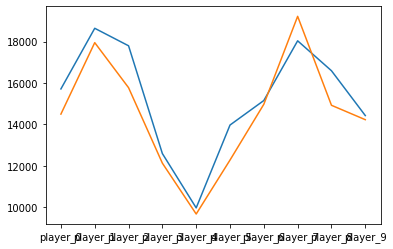

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_income)

<AxesSubplot:xlabel='championName'>

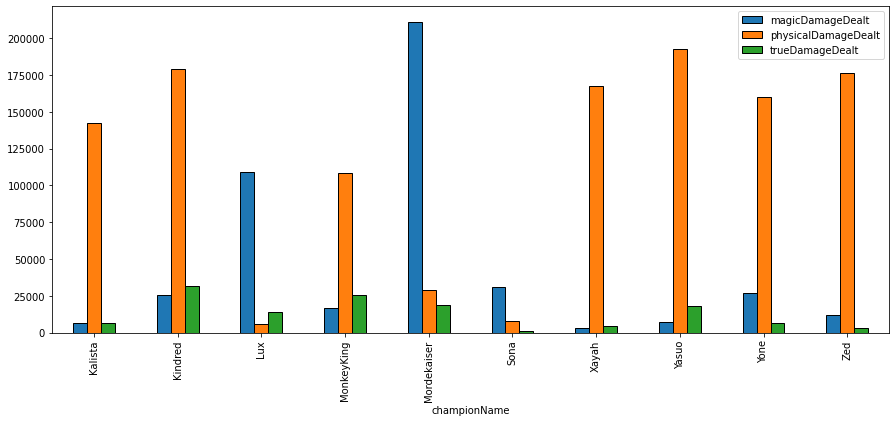

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize']=(15,6)
pd.pivot_table(df,values=['magicDamageDealt','physicalDamageDealt','trueDamageDealt'], index='championName').plot(kind='bar',
                                                                                       edgecolor='k',linewidth='1')

<AxesSubplot:xlabel='championName'>

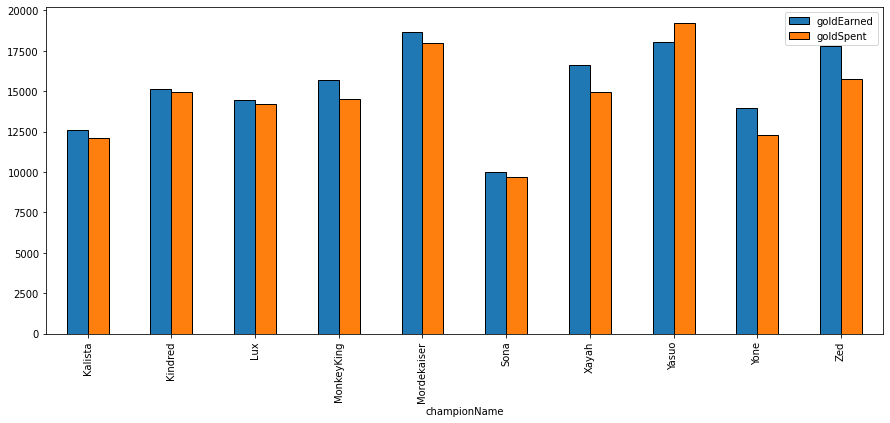

In [13]:
plt.rcParams['figure.figsize']=(15,6)
pd.pivot_table(df,values=['goldEarned','goldSpent'], index='championName').plot(kind='bar',
                                                                                       edgecolor='k',linewidth='1')

<AxesSubplot:xlabel='championName'>

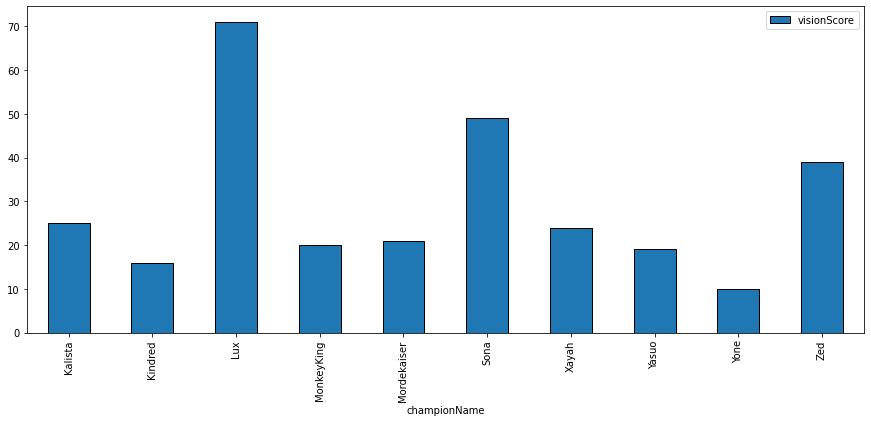

In [14]:
plt.rcParams['figure.figsize']=(15,6)
pd.pivot_table(df,values=['visionScore'], index='championName').plot(kind='bar',
                                                                                       edgecolor='k',linewidth='1')

In [22]:
df_combat

,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,magicDamageDealt,magicDamageDealtToChampions,magicDamageTaken,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,timeCCingOthers,totalTimeCCDealt
player_0,7868,18225,7868,16688,3418,13260,108400,22281,28603,150398,25813,45569,25310,114,3706,22,56
player_1,1651,36147,1651,211158,19003,10947,29045,2889,38259,258626,23479,52825,18419,1587,3617,16,271
player_2,2899,2899,2899,11948,1347,8557,176543,34498,22501,191546,37221,33285,3054,1374,2227,9,282
player_3,2293,9853,2293,6382,1800,13259,142549,18150,21961,155635,20413,36686,6704,462,1465,20,187
player_4,942,3248,942,30774,8832,7289,7932,1606,18662,39508,11239,27539,800,800,1587,13,40
player_5,1618,8665,1618,27083,5110,6734,160423,9717,22682,193724,17233,30057,6217,2405,640,24,143
player_6,0,28164,0,25246,4053,10051,179010,17908,26645,236159,24889,36988,31903,2926,292,5,279
player_7,4633,22641,4633,7358,2180,8317,192469,32671,27829,218157,41061,37894,18328,6209,1748,26,142
player_8,4785,9114,4785,3326,1957,7214,167285,28314,20662,174870,30789,28984,4258,518,1108,20,89
player_9,555,3159,555,109046,37982,7244,6037,1689,13759,129257,40216,21556,14174,544,552,64,347


<AxesSubplot:xlabel='championName'>

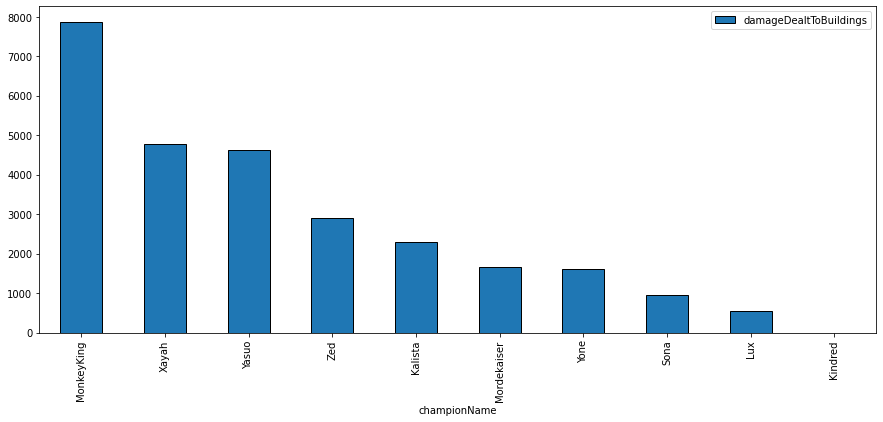

In [37]:
pd.pivot_table(df,
               values=df[['damageDealtToBuildings']],index='championName').sort_values('damageDealtToBuildings', ascending=False).plot(
    kind='bar',edgecolor='k',linewidth=1)

In [31]:
df_combat

,championName,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,magicDamageDealt,magicDamageDealtToChampions,magicDamageTaken,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,timeCCingOthers,totalTimeCCDealt
player_0,MonkeyKing,7868,18225,7868,16688,3418,13260,108400,22281,28603,150398,25813,45569,25310,114,3706,22,56
player_1,Mordekaiser,1651,36147,1651,211158,19003,10947,29045,2889,38259,258626,23479,52825,18419,1587,3617,16,271
player_2,Zed,2899,2899,2899,11948,1347,8557,176543,34498,22501,191546,37221,33285,3054,1374,2227,9,282
player_3,Kalista,2293,9853,2293,6382,1800,13259,142549,18150,21961,155635,20413,36686,6704,462,1465,20,187
player_4,Sona,942,3248,942,30774,8832,7289,7932,1606,18662,39508,11239,27539,800,800,1587,13,40
player_5,Yone,1618,8665,1618,27083,5110,6734,160423,9717,22682,193724,17233,30057,6217,2405,640,24,143
player_6,Kindred,0,28164,0,25246,4053,10051,179010,17908,26645,236159,24889,36988,31903,2926,292,5,279
player_7,Yasuo,4633,22641,4633,7358,2180,8317,192469,32671,27829,218157,41061,37894,18328,6209,1748,26,142
player_8,Xayah,4785,9114,4785,3326,1957,7214,167285,28314,20662,174870,30789,28984,4258,518,1108,20,89
player_9,Lux,555,3159,555,109046,37982,7244,6037,1689,13759,129257,40216,21556,14174,544,552,64,347


In [ ]:
p = riot_api()

In [ ]:
riot.get_summoner_by_name('veteranmaestro')

In [ ]:
p.df = {'A':'1','B':'2'}

In [ ]:
p.df

In [ ]:
len(p.get_matches_by_summoner_name('veteranmaestro'))

In [ ]:
p.get_match_info_by_match_id('TR1_1191046744')

In [ ]:
p.performance_metrics(p.get_match_info_by_match_id('TR1_1191481444'))

In [ ]:
p.df

In [ ]:
p.g

In [ ]:
p.skills

In [ ]:
p.damage_true

In [ ]:
p.get_matches_by_summoner_name('LordDabulu')

In [ ]:
p.get_summoner_by_name('rolatweete')

In [ ]:
match_0 = p.get_matches_by_summoner_name('rolatweete')[0]

In [ ]:
p.get_match_info_by_match_id(match_0)

In [ ]:
p.get_game_timeline_by_match_id(match_0)

In [ ]:
p.get_league_entries_by_summoner_id('zmLuQTBd8tZQmblKL07PFnWKfxQ432NiSAdgya0ePfAupQ')

In [ ]:
p.get_all_league_entries_by_queue_tier_division()

In [ ]:
p.get_champion_mastery_by_summoner_id_champion_id('zmLuQTBd8tZQmblKL07PFnWKfxQ432NiSAdgya0ePfAupQ','517')

In [ ]:
p.get_champion_masteries_by_summoner_id('zmLuQTBd8tZQmblKL07PFnWKfxQ432NiSAdgya0ePfAupQ')

In [ ]:
p.get_total_mastery_score_by_summoner_id('zmLuQTBd8tZQmblKL07PFnWKfxQ432NiSAdgya0ePfAupQ')

In [ ]:
p.performance_metrics(match_0)

In [ ]:
match_0

In [ ]:
p.get_match_info_by_match_id('zmLuQTBd8tZQmblKL07PFnWKfxQ432NiSAdgya0ePfAupQp')

In [ ]:
def okaq(x):
    x+=2
    return x

okaq(4)